<!--Estudo de caso - classificação de vinhos 23/03/2025 -->
# <font color='Red'>Classificação de Vinhos</font>
## <font color='Red'>Pipelines de ETL e Machine Learning com Apache Spark</font>
## 
### <font color='Red'>Deploy e Inferência de Modelos de Machine Learning com MLflow e Databricks</font>

## Instalação de Pacotes no Databricks

In [1]:
!pip install -q --upgrade pip

In [2]:
!pip install -q missingno==0.5.2

In [3]:
!pip install -q sweetviz==2.3.1

In [4]:
!pip install -q mlflow==2.19.0

In [5]:
!pip install -q scikit-learn==1.3.0

In [6]:
!pip install -q imbalanced-learn==0.11.0

In [7]:
%restart_python

UsageError: Line magic function `%restart_python` not found.


## Carregando Pacotes

In [8]:
# Manipulação de dados e gráficos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sweetviz as sv
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

/Users/silmarabasso/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando os Dados a Partir da Web

In [9]:
# URL para o dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

In [10]:
# Nomes das colunas
column_names = [
    "CLASS", "ALCOHOL", "MALICACID", "ASH", "ALCALINITY_OF_ASH",
    "MAGNESIUM", "TOTAL_PHENOLS", "FLAVANOIDS", "NONFLAVANOID_PHENOLS",
    "PROANTHOCYANINS", "COLOR_INTENSITY", "HUE",
    "DILUTED_WINES", "PROLINE"
] 

In [11]:
# Importa os dados e cria o dataframe
df = pd.read_csv(url, header = None, names = column_names)

In [12]:
df.shape

(178, 14)

In [13]:
df.head()

,CLASS,ALCOHOL,MALICACID,ASH,ALCALINITY_OF_ASH,MAGNESIUM,TOTAL_PHENOLS,FLAVANOIDS,NONFLAVANOID_PHENOLS,PROANTHOCYANINS,COLOR_INTENSITY,HUE,DILUTED_WINES,PROLINE
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Pipeline de Análise Exploratória

Veja a definição no videobook do Capítulo 15.

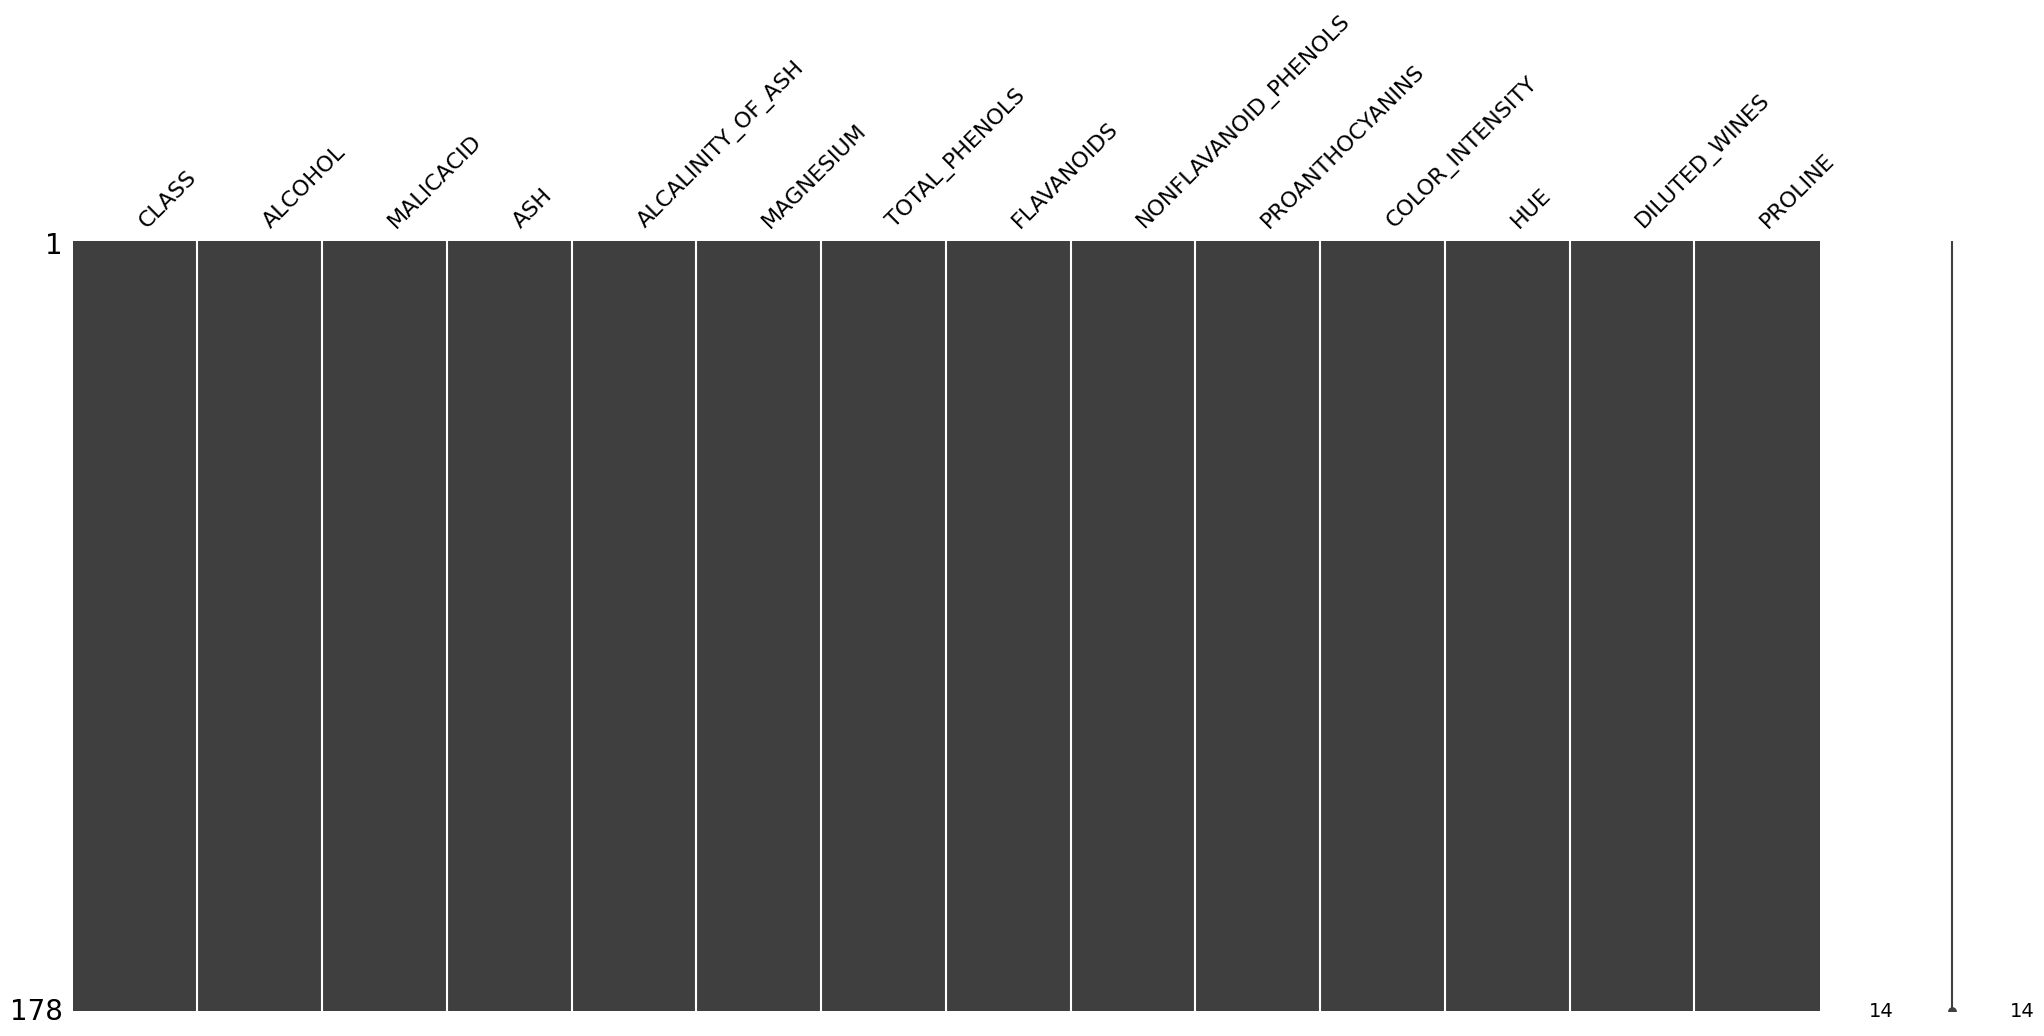

In [14]:
# Cria a matriz de valores ausentes
msno.matrix(df)
plt.show()

In [16]:
# Cria o relatório de análise
report = sv.analyze(df)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


In [18]:
# Imprime o relatório (pode ser acessado direto pelo disco)
report.show_html("ml_vinhos_sweetviz_report.html")

Report ml_vinhos_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


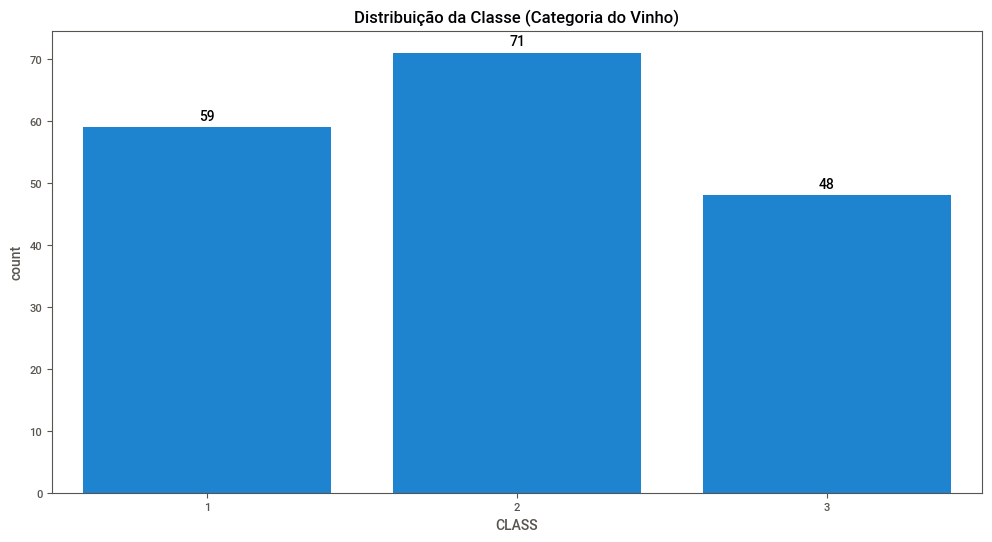

In [19]:
# Plot
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'CLASS', data = df)
plt.title('Distribuição da Classe (Categoria do Vinho)')
for container in ax.containers:
    ax.bar_label(container, fmt = '%d', label_type = 'edge', padding = 3)
plt.show()

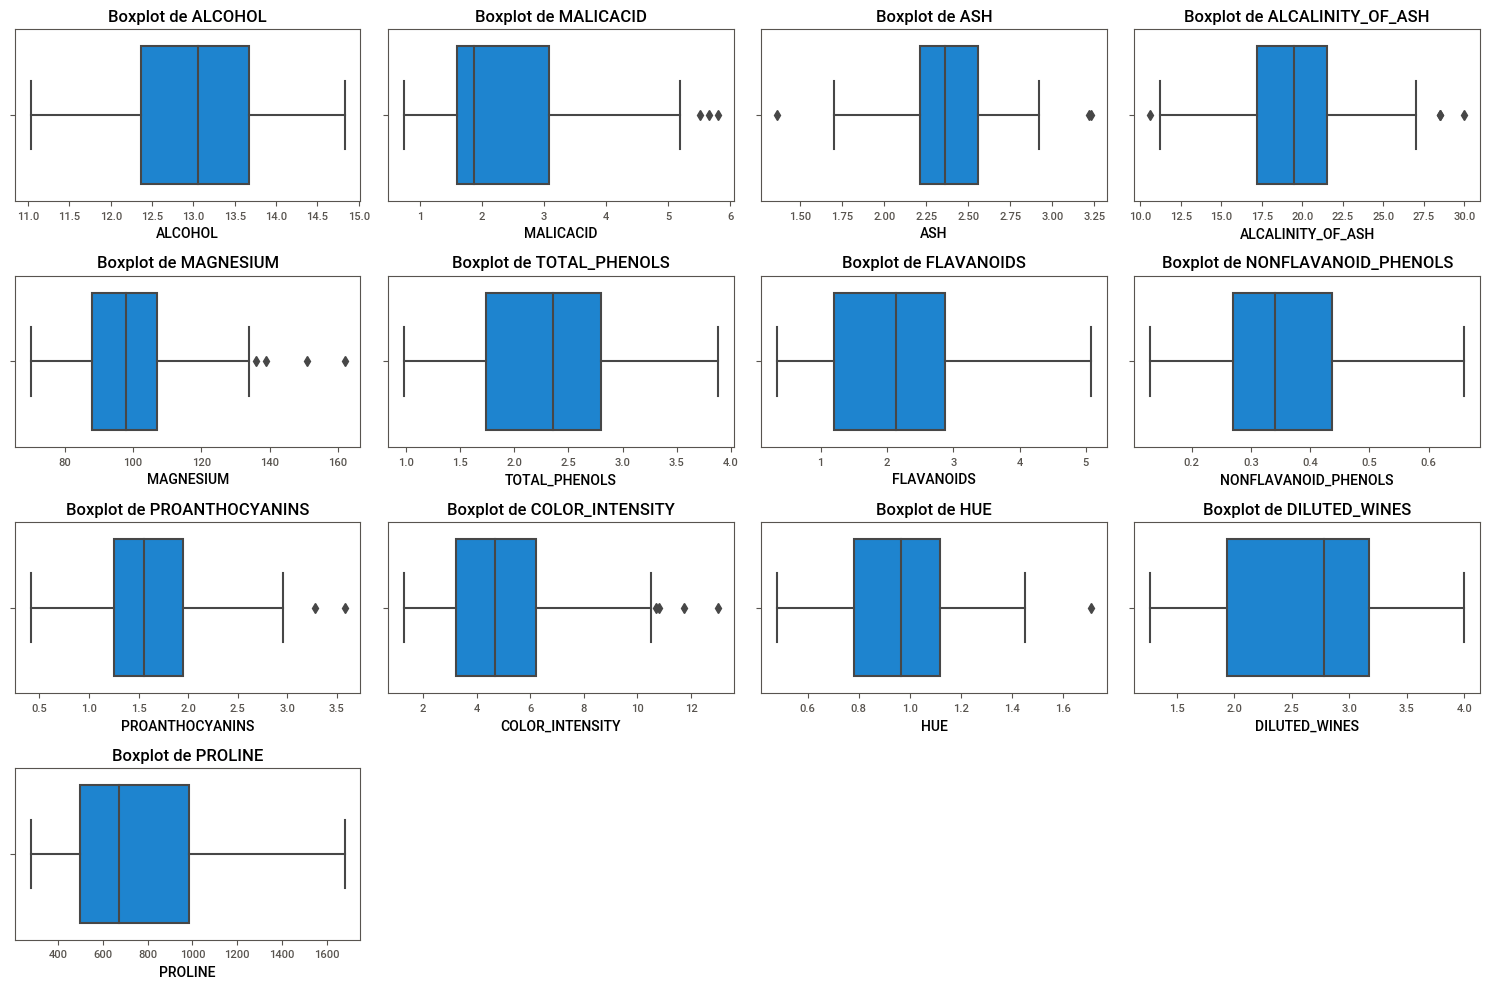

In [0]:
# Plot
plt.figure(figsize = (15, 10))
for i, col in enumerate(column_names[1:]): 
    plt.subplot(4, 4, i+1)
    sns.boxplot(x = df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()  
plt.show()

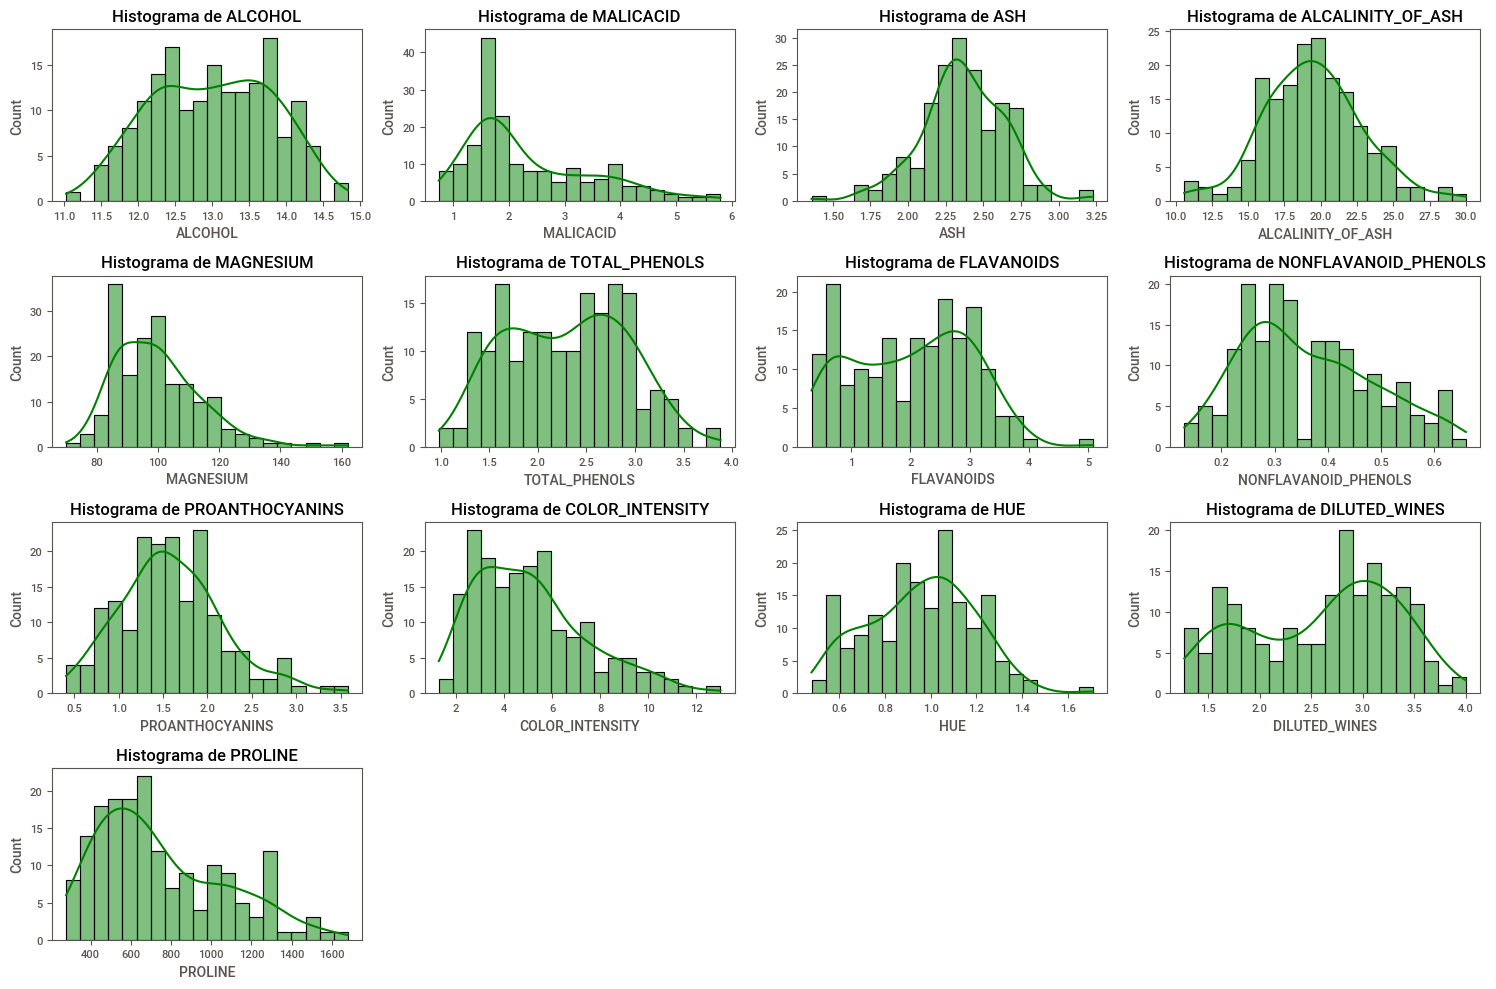

In [20]:
# Plot
plt.figure(figsize = (15, 10))
for i, col in enumerate(column_names[1:]): 
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde = True, bins = 20, color = 'green', edgecolor = 'black')
    plt.title(f'Histograma de {col}')
plt.tight_layout()
plt.show()

## Pipeline de Limpeza dos Dados

Veja a definição no videobook do Capítulo 15.

In [ ]:
# Define a função para identificar outliers em um DataFrame
def trata_valores_extremos(df, columnas):
    
    # Itera sobre cada coluna fornecida na lista de colunas
    for col in columnas:
        
        # Calcula o primeiro quartil (Q1) da coluna
        Q1 = df[col].quantile(0.25)
        
        # Calcula o terceiro quartil (Q3) da coluna
        Q3 = df[col].quantile(0.75)
        
        # Calcula o intervalo interquartil (IQR)
        IQR = Q3 - Q1
        
        # Define o limite inferior para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        
        # Define o limite superior para identificar outliers
        limite_superior = Q3 + 1.5 * IQR
        
        # Substitui valores abaixo do limite inferior pelo próprio limite inferior
        df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
        
        # Substitui valores acima do limite superior pelo próprio limite superior
        df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])
        
    # Retorna o DataFrame atualizado com os outliers tratados
    return df

In [22]:
column_names

['CLASS',
 'ALCOHOL',
 'MALICACID',
 'ASH',
 'ALCALINITY_OF_ASH',
 'MAGNESIUM',
 'TOTAL_PHENOLS',
 'FLAVANOIDS',
 'NONFLAVANOID_PHENOLS',
 'PROANTHOCYANINS',
 'COLOR_INTENSITY',
 'HUE',
 'DILUTED_WINES',
 'PROLINE']

In [23]:
# Extrai as colunas, exceto a variável target
columnas_numericas = column_names[1:] 

In [24]:
columnas_numericas

['ALCOHOL',
 'MALICACID',
 'ASH',
 'ALCALINITY_OF_ASH',
 'MAGNESIUM',
 'TOTAL_PHENOLS',
 'FLAVANOIDS',
 'NONFLAVANOID_PHENOLS',
 'PROANTHOCYANINS',
 'COLOR_INTENSITY',
 'HUE',
 'DILUTED_WINES',
 'PROLINE']

In [ ]:
# Aplica a função
df_RIQ1 = trata_valores_extremos(df, columnas_numericas)

In [27]:
# Define a função para remover outliers em colunas específicas de um DataFrame
def trata_outliers(df, columnas):
    
    # Itera sobre cada coluna fornecida na lista de colunas
    for col in columnas:
        
        # Calcula o primeiro quartil (Q1) da coluna
        Q1 = df[col].quantile(0.25)
        
        # Calcula o terceiro quartil (Q3) da coluna
        Q3 = df[col].quantile(0.75)
        
        # Calcula o intervalo interquartil (IQR)
        IQR = Q3 - Q1
        
        # Define o limite inferior para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        
        # Define o limite superior para identificar outliers
        limite_superior = Q3 + 1.5 * IQR

        # Filtra o DataFrame para manter apenas os valores dentro dos limites
        df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]
        
    # Retorna o DataFrame atualizado sem os outliers
    return df

In [28]:
# Aplica a função
df_RIQ2 = trata_outliers(df, columnas_numericas)

In [29]:
# Define a função para substituir outliers em colunas específicas de um DataFrame
def substitui_outliers(df, columnas):
    
    # Itera sobre cada coluna fornecida na lista de colunas
    for col in columnas:
        
        # Calcula o primeiro quartil (Q1) da coluna
        Q1 = df[col].quantile(0.25)
        
        # Calcula o terceiro quartil (Q3) da coluna
        Q3 = df[col].quantile(0.75)
        
        # Calcula o intervalo interquartil (IQR)
        IQR = Q3 - Q1
        
        # Define o limite inferior para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        
        # Define o limite superior para identificar outliers
        limite_superior = Q3 + 1.5 * IQR
        
        # Substitui os valores abaixo do limite inferior pelo primeiro quartil (Q1)
        df[col] = np.where(df[col] < limite_inferior, Q1, df[col])
        
        # Substitui os valores acima do limite superior pelo terceiro quartil (Q3)
        df[col] = np.where(df[col] > limite_superior, Q3, df[col])
        
    # Retorna o DataFrame atualizado com os outliers substituídos
    return df

In [30]:
# Aplica a função
df_RIQ3 = substitui_outliers(df, columnas_numericas)

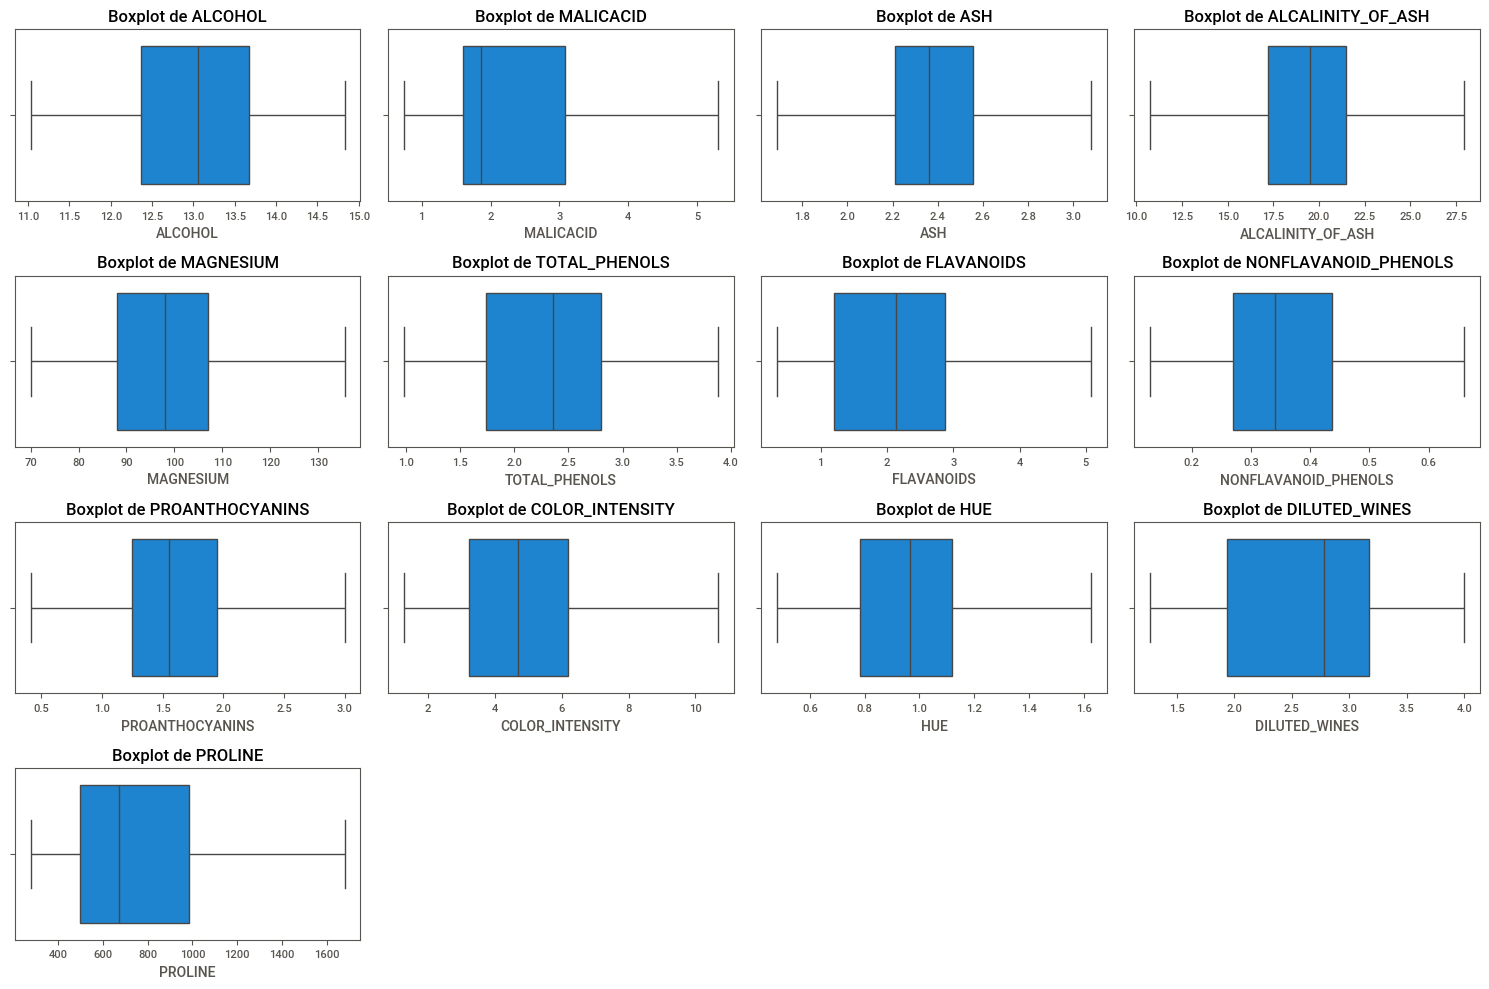

In [31]:
# Plot
plt.figure(figsize = (15, 10))
for i, col in enumerate(column_names[1:]): 
    plt.subplot(4, 4, i+1)
    sns.boxplot(x = df_RIQ3[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

## Pipeline de Balanceamento de Classes

Veja a definição no videobook do Capítulo 15.

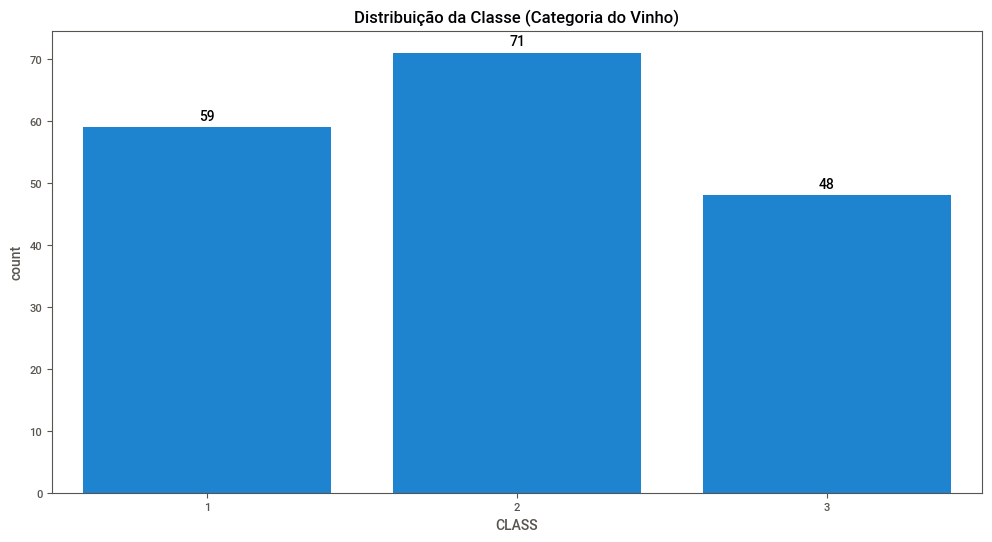

In [32]:
# Plot
plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'CLASS', data = df)
plt.title('Distribuição da Classe (Categoria do Vinho)')
for container in ax.containers:
    ax.bar_label(container, fmt = '%d', label_type = 'edge', padding = 3)
plt.show()

In [33]:
# Separa X (entrada) e y (saída)
X = df_RIQ3.drop("CLASS", axis = 1)
y = df_RIQ3["CLASS"]

In [35]:
# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [36]:
# Cria o balanceador de classe
smote = SMOTE(random_state = 42)

In [37]:
# Treina e aplica o balanceador nos dados de treino
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [38]:
print("Distribuição de Classe Antes do SMOTE:")
print(y_train.value_counts())

Distribuição de Classe Antes do SMOTE:
CLASS
2    57
1    47
3    38
Name: count, dtype: int64


In [39]:
print("\nDistribuição de Classe Após o SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Distribuição de Classe Após o SMOTE:
CLASS
1    57
3    57
2    57
Name: count, dtype: int64


## Pipeline de Pré-Processamento de Dados


In [40]:
# Cria o padronizador
scaler = StandardScaler()

In [41]:
# Aplica o fit em treino e transform em treino e teste
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Criação do Experimento no MLflow


In [42]:
import logging
logging.getLogger("mlflow").setLevel(logging.WARNING)

In [43]:
# Registra o experimento (use o e-mail que você usou para criar o cadastro no Databricks)
# mlflow.set_experiment("/Users/silmarabasso@gmail.com/ml_vinhos")
mlflow.set_experiment("/Users/silmarabasso/repos/inferencia-mlflow-databricks/exp_ml_vinhos")

<Experiment: artifact_location='file:///Users/silmarabasso/repos/inferencia-mlflow-databricks/mlruns/694754763658029394', creation_time=1742816597926, experiment_id='694754763658029394', last_update_time=1742816597926, lifecycle_stage='active', name='/Users/silmarabasso/repos/inferencia-mlflow-databricks/exp_ml_vinhos', tags={}>

In [44]:
# Define a função para registrar a matriz de confusão e suas métricas no MLflow
def registra_matriz_confusao_mlflow(y_test, y_pred, classes, run_name = "Modelo"):
    
    # Calcula a matriz de confusão com base nos valores reais e previstos
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Extrai o número de verdadeiros positivos da matriz de confusão
    true_positive = conf_matrix[0][0]
    
    # Extrai o número de falsos positivos da matriz de confusão
    false_positive = conf_matrix[0][1]
    
    # Extrai o número de falsos negativos da matriz de confusão
    false_negative = conf_matrix[1][0]
    
    # Extrai o número de verdadeiros negativos da matriz de confusão
    true_negative = conf_matrix[1][1]
    
    # Inicia uma execução (run) no MLflow com o nome especificado
    with mlflow.start_run(run_name = run_name):
        
        # Registra o número de verdadeiros positivos como uma métrica no MLflow
        mlflow.log_metric("true_positive", true_positive)
        
        # Registra o número de falsos positivos como uma métrica no MLflow
        mlflow.log_metric("false_positive", false_positive)
        
        # Registra o número de falsos negativos como uma métrica no MLflow
        mlflow.log_metric("false_negative", false_negative)
        
        # Registra o número de verdadeiros negativos como uma métrica no MLflow
        mlflow.log_metric("true_negative", true_negative)

        # Cria uma figura para a matriz de confusão
        plt.figure(figsize = (8, 6))
        
        # Plot da matriz de confusão usando um mapa de calor
        # https://matplotlib.org/stable/users/explain/colors/colormaps.html
        sns.heatmap(conf_matrix, 
                    annot = True, 
                    fmt = "d", 
                    cmap = "Purples", 
                    xticklabels = classes, 
                    yticklabels = classes)
        
        # Adiciona um título à matriz de confusão
        plt.title(f'Matriz de Confusão - {run_name}')
        
        # Adiciona um rótulo ao eixo X
        plt.xlabel("Valores Previstos")
        
        # Adiciona um rótulo ao eixo Y
        plt.ylabel("Valores Reais")
        
        # Define o caminho para salvar a matriz de confusão como uma imagem
        confusion_matrix_path = f"vinhos_confusion_matrix_{run_name}.png"
        
        # Salva a figura da matriz de confusão
        plt.savefig(confusion_matrix_path)
        
        # Fecha a figura para liberar memória
        plt.close()
        
        # Registra a imagem da matriz de confusão como um artefato no MLflow
        mlflow.log_artifact(confusion_matrix_path, "confusion_matrix")
        
        # Remove o arquivo da matriz de confusão do sistema após o upload
        os.remove(confusion_matrix_path)
        
        # Exibe uma mensagem indicando que a matriz de confusão foi registrada no MLflow
        print(f"Matriz de Confusão para {run_name} registrada no MLflow.")

In [45]:
# Define a função para criar e exibir a matriz de confusão
def cria_confusion_matrix(y_true, y_pred, classes, titulo = "Matriz de Confusão"):
    
    # Calcula a matriz de confusão com base nos valores reais e previstos
    cm = confusion_matrix(y_true, y_pred)
    
    # Cria uma nova figura para exibir a matriz de confusão
    plt.figure(figsize = (8, 6))
    
    # Plota a matriz de confusão usando um mapa de calor
    sns.heatmap(cm, 
                annot = True, 
                fmt = "d", 
                cmap = "Purples", 
                xticklabels = classes, 
                yticklabels = classes)
    
    # Adiciona um título à matriz de confusão
    plt.title(titulo)
    
    # Adiciona um rótulo ao eixo X
    plt.xlabel("Valores Previstos")
    
    # Adiciona um rótulo ao eixo Y
    plt.ylabel("Valores Reais")
    
    # Exibe a matriz de confusão na tela
    plt.show()

In [46]:
# Lista de classes
classes = ['Classe 1', 'Classe 2', 'Classe 3']

## Pipeline de Treinamento do Modelo de Machine Learning

### Versão 1 do Modelo com Regressão Logística

In [47]:
# Inicia uma execução (run) no MLflow com o nome "Logistic Regression Vinhos"
with mlflow.start_run(run_name = "Logistic Regression VWine"):
    
    # Cria o modelo de Regressão Logística com os parâmetros especificados
    lr = LogisticRegression(max_iter = 100, solver = 'lbfgs', random_state = 42)
    
    # Treina o modelo usando os dados de treinamento balanceados e escalados
    lr.fit(X_train_balanced_scaled, y_train_balanced)
    
    # Realiza as previsões nos dados de teste escalados
    y_pred = lr.predict(X_test_scaled)
    
    # Calcula as probabilidades preditivas nos dados de teste
    y_proba = lr.predict_proba(X_test_scaled)
    
    # Calcula a acurácia do modelo
    acc = accuracy_score(y_test, y_pred)
    
    # Calcula a métrica ROC AUC com o método de multi-classes "one-vs-rest"
    roc_auc = roc_auc_score(y_test, y_proba, multi_class = 'ovr')
    
    # Exemplo de entrada para ser registrado no MLflow
    input_example = X_test_scaled
    
    # Infere a assinatura do modelo (tipos de entrada e saída)
    signature = infer_signature(X_test_scaled, y_pred)
    
    # Registra os parâmetros e métricas do modelo no MLflow
    mlflow.log_param("Modelo", "Regressão Logística")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", roc_auc)
    
    # Registra o modelo treinado no MLflow com assinatura e exemplo de entrada
    mlflow.sklearn.log_model(lr, "modelo", signature = signature, input_example = input_example)
    
    # Exibe as métricas calculadas no console
    print("Logistic Regression - Accuracy:", acc)
    print("Logistic Regression - ROC AUC:", roc_auc)

Logistic Regression - Accuracy: 0.9722222222222222
Logistic Regression - ROC AUC: 1.0


In [48]:
# Extrai as previsões
y_pred_lr = lr.predict(X_test_scaled)

In [52]:
# Registra a matriz de confusão como artefato no MLflow
registra_matriz_confusao_mlflow(y_test, y_pred_lr, classes, run_name = "Logistic Regression VWine")

Matriz de Confusão para Logistic Regression VWine registrada no MLflow.


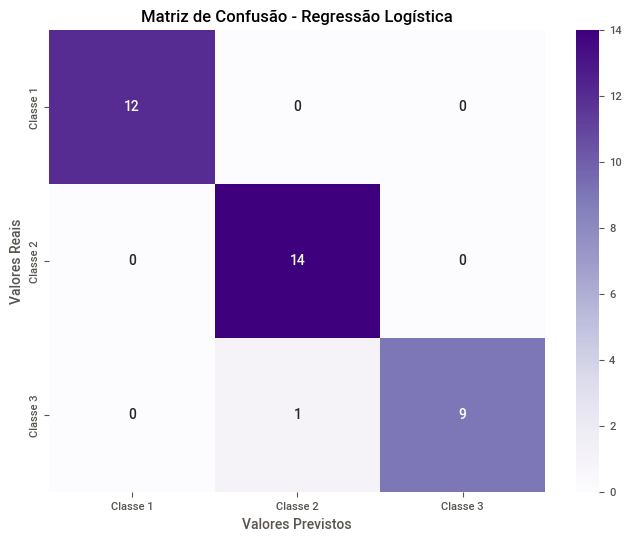

In [53]:
# Plot da matriz
cria_confusion_matrix(y_test, y_pred_lr, classes, titulo = "Matriz de Confusão - Regressão Logística")

### Versão 2 do Modelo com Random Forest

In [54]:
# Inicia uma execução (run) no MLflow com o nome "Random Forest Vinhos"
with mlflow.start_run(run_name = "Random Forest Vinhos"):
    
    # Cria o modelo de Random Forest com 10 estimadores e estado aleatório definido
    rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
    
    # Treina o modelo usando os dados de treinamento balanceados e escalados
    rf.fit(X_train_balanced_scaled, y_train_balanced)
    
    # Realiza as previsões nos dados de teste escalados
    y_pred_rf = rf.predict(X_test_scaled)
    
    # Calcula as probabilidades preditivas nos dados de teste
    y_proba_rf = rf.predict_proba(X_test_scaled)
    
    # Calcula a acurácia do modelo
    acc_rf = accuracy_score(y_test, y_pred_rf)
    
    # Calcula a métrica ROC AUC com o método de multi-classes "one-vs-rest"
    roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class = 'ovr')
    
    # Define um exemplo de entrada para ser registrado no MLflow
    input_example = X_test_scaled
    
    # Infere a assinatura do modelo (tipos de entrada e saída)
    signature = infer_signature(X_test_scaled, y_pred_rf)
    
    # Registra os parâmetros e métricas do modelo no MLflow
    mlflow.log_param("Modelo", "Random Forest")
    mlflow.log_metric("Accuracy", acc_rf)
    mlflow.log_metric("ROC_AUC", roc_auc_rf)
    
    # Registra o modelo treinado no MLflow com assinatura e exemplo de entrada
    mlflow.sklearn.log_model(rf, "modelo", signature = signature, input_example = input_example)
    
    # Exibe as métricas calculadas no console
    print("Random Forest - Accuracy:", acc_rf)
    print("Random Forest - ROC AUC:", roc_auc_rf)

Random Forest - Accuracy: 1.0
Random Forest - ROC AUC: 1.0


In [55]:
# Extrai as previsões
y_pred_rf = rf.predict(X_test_scaled)

In [56]:
# Registra a matriz de confusão como artefato no MLflow
registra_matriz_confusao_mlflow(y_test, y_pred_rf, classes, run_name = "Random Forest Vinhos")

Matriz de Confusão para Random Forest Vinhos registrada no MLflow.


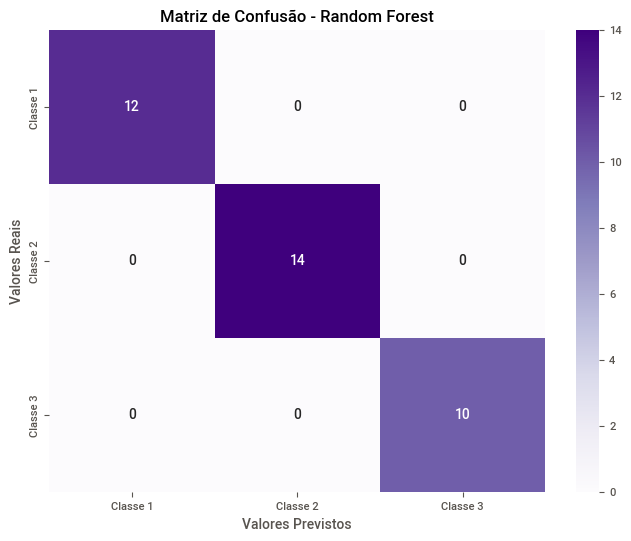

In [57]:
# Plot da matriz
cria_confusion_matrix(y_test, y_pred_rf, classes, titulo = "Matriz de Confusão - Random Forest")

## Deploy e Pipeline de Inferência

In [58]:
# Lista com novos registros de características de 3 vinhos (3 linhas)
novos_dados = [
    [13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
    [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520],
    [11.27, 0.84, 2.18, 17.8, 67, 2.34, 0.49, 0.39, 0.71, 4.41, 1.12, 1.90, 765]
]

In [59]:
# Prepara o dataframe
inferencias_df = pd.DataFrame(novos_dados, columns = X.columns)

In [60]:
inferencias_df.head()

,ALCOHOL,MALICACID,ASH,ALCALINITY_OF_ASH,MAGNESIUM,TOTAL_PHENOLS,FLAVANOIDS,NONFLAVANOID_PHENOLS,PROANTHOCYANINS,COLOR_INTENSITY,HUE,DILUTED_WINES,PROLINE
0,13.72,1.43,2.50,16.7,108,3.40,3.67,0.19,2.04,6.80,0.89,2.87,1285
1,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
2,11.27,0.84,2.18,17.8,67,2.34,0.49,0.39,0.71,4.41,1.12,1.90,765


In [61]:
# Aplica a padronização
inferencias_scaled = scaler.transform(inferencias_df)

Na execução local, vá até a pasta onde estão as execuções do MLflow (mlruns) e identifique a pasta onde tem o artefato do modelo. Então coloque na célula abaixo. Na plataforma Databricks, clique no link em uma das células anteriores e então verifique o id da execução.

In [62]:
# Caminho da pasta com o modelo (altere o id da execução)
model_uri = "runs:/df95ae4eed5f45beabdc0cbcbf0e3139/modelo"

In [63]:
# Carrega o modelo do disco
rf_model = mlflow.sklearn.load_model(model_uri)

In [64]:
# Previsões de classe
previsoes_de_classe = rf_model.predict(inferencias_scaled)
for i, pred in enumerate(previsoes_de_classe):
    print(f"Amostra {i+1}: Previsão -> Classe {pred}")

Amostra 1: Previsão -> Classe 1
Amostra 2: Previsão -> Classe 2
Amostra 3: Previsão -> Classe 2


In [65]:
# Previsões de probabilidade
previsoes_de_probabilidades = rf_model.predict_proba(inferencias_scaled)
for i, probs in enumerate(previsoes_de_probabilidades):
    print(f"\nAmostra {i+1}: Probabilidades -> {dict(zip(classes, probs))}")


Amostra 1: Probabilidades -> {'Classe 1': 1.0, 'Classe 2': 0.0, 'Classe 3': 0.0}

Amostra 2: Probabilidades -> {'Classe 1': 0.0, 'Classe 2': 0.9, 'Classe 3': 0.1}

Amostra 3: Probabilidades -> {'Classe 1': 0.1, 'Classe 2': 0.6, 'Classe 3': 0.3}


Agora é só registrar seu modelo e depois criar o endpoint para servir

# Fim